In [2]:
  pip install findspark


Note: you may need to restart the kernel to use updated packages.


In [3]:
  import findspark
  findspark.init()

  from pyspark.sql import SparkSession
  spark = SparkSession.builder.appName("Andra").getOrCreate()

25/10/25 13:04:42 WARN Utils: Your hostname, andra-VirtualBox resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/10/25 13:04:42 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/25 13:04:43 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/25 13:04:58 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [16]:

data = [
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
]
columns = ['Name', 'Age', 'Gender', 'Salary', 'DeptId']
df = spark.createDataFrame(data, schema=columns)
df.createOrReplaceTempView('employees')

print("menampilkan semua data employes")
spark.sql('SELECT * FROM employees').show()
print("menampilkan nama dan usia di dataframe employes dimana yang memiliki gaji lebih dari 3000")
spark.sql('SELECT Name, Age FROM employees WHERE Salary > 3000').show()
print("Rata rata gaji yang ada di tabel employes")
spark.sql('SELECT AVG(Salary) FROM employees').show()
print(" queries sederhana lainnya")
print("Urutkan karyawan berdasarkan gaji tertinggi")
spark.sql('SELECT Name, Salary FROM employees ORDER BY Salary DESC').show()
print("Tampilkan karyawan laki-laki saja")
spark.sql("SELECT Name, Age, Salary FROM employees WHERE Gender = 'M'").show()
print("Hitung jumlah karyawan per departemen")
spark.sql('SELECT DeptId, COUNT(*) AS TotalEmployees FROM employees GROUP BY DeptId').show()
print("Cari rata-rata gaji per jenis kelamin")
spark.sql('SELECT Gender, AVG(Salary) AS AverageSalary FROM employees GROUP BY Gender').show()
print("Temukan karyawan dengan gaji tertinggi")
spark.sql('SELECT Name, Salary FROM employees ORDER BY Salary DESC LIMIT 1').show()
print("total gaji semua karyawan")
spark.sql('SELECT SUM(Salary) AS TotalSalary FROM employees').show()
print("Cek karyawan dengan usia antara 25 dan 35 tahun")
spark.sql('SELECT Name, Age, Salary FROM employees WHERE Age BETWEEN 25 AND 35').show()

print("menghitung total gaji berdasarkan jenis kelamin dan usia.")
spark.sql('''
SELECT Gender, SUM(Salary) as TotalSalary, Age
FROM employees
GROUP BY Gender, Age
ORDER BY Age
''').show()

print("Rata rata gaji perdepartemen")
# Rata-rata gaji per departemen
spark.sql('''
SELECT DeptId, ROUND(AVG(Salary), 2) AS AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY DeptId
''').show()

print ("Karyawan dengan gaji di atas rata-rata untuk gender masing-masing")
spark.sql('''
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN (
    SELECT Gender, AVG(Salary) AS AvgGenderSalary
    FROM employees
    GROUP BY Gender
) g ON e.Gender = g.Gender
WHERE e.Salary > g.AvgGenderSalary
ORDER BY e.Gender, e.Salary DESC
''').show()

print("Ranking karyawan berdasarkan gaji dalam departemen")
spark.sql('''
SELECT 
    Name, DeptId, Salary,
    RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS SalaryRank
FROM employees
ORDER BY DeptId, SalaryRank
''').show()

print("variasi lain Rata rata gaji perdepartemen")
# Menambahkan jumlah karyawan per departemen
spark.sql('''
SELECT DeptId, 
       COUNT(*) AS JumlahKaryawan, 
       ROUND(AVG(Salary), 2) AS AvgSalary
FROM employees
GROUP BY DeptId
ORDER BY AvgSalary DESC
''').show()

print("Karyawan dengan gaji di atas rata-rata untuk gender masing-masing Versi alternatif (pakai WITH untuk lebih rapi")
spark.sql('''
WITH GenderAvg AS (
    SELECT Gender, AVG(Salary) AS AvgGenderSalary
    FROM employees
    GROUP BY Gender
)
SELECT e.Name, e.Gender, e.Salary
FROM employees e
JOIN GenderAvg g ON e.Gender = g.Gender
WHERE e.Salary > g.AvgGenderSalary
''').show()
print("Versi lain — tampilkan juga yang ranking tertinggi saja per departemen:")
spark.sql('''
SELECT Name, DeptId, Salary
FROM (
    SELECT 
        Name, DeptId, Salary,
        RANK() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankInDept
    FROM employees
) ranked
WHERE RankInDept = 1
''').show()

print("Penggunaan Window Functions dan Subqueries")
print("top 3 karyawan dalam kelompok usia tertentu.")
spark.sql('''
SELECT *
FROM (
    SELECT Name, Age, Salary,
           ROW_NUMBER() OVER (PARTITION BY Age ORDER BY Salary DESC) AS rank
    FROM employees
)
WHERE rank <= 3
ORDER BY Age, rank
''').show()

print("top 2 per departemen, tapi hanya untuk departemen yang rata-rata gajinya di atas 3000:")
spark.sql('''
WITH HighPaidDept AS (
    SELECT DeptId
    FROM employees
    GROUP BY DeptId
    HAVING AVG(Salary) > 3000
),
Ranked AS (
    SELECT Name, DeptId, Salary,
           ROW_NUMBER() OVER (PARTITION BY DeptId ORDER BY Salary DESC) AS RankInDept
    FROM employees
)
SELECT *
FROM Ranked
WHERE DeptId IN (SELECT DeptId FROM HighPaidDept)
  AND RankInDept <= 2
ORDER BY DeptId, RankInDept
''').show()



menampilkan semua data employes
+-----+---+------+------+------+
| Name|Age|Gender|Salary|DeptId|
+-----+---+------+------+------+
|James| 34|     M|  3000|     1|
| Anna| 28|     F|  4100|     2|
|  Lee| 23|     M|  2700|     1|
+-----+---+------+------+------+

menampilkan nama dan usia di dataframe employes dimana yang memiliki gaji lebih dari 3000
+----+---+
|Name|Age|
+----+---+
|Anna| 28|
+----+---+

Rata rata gaji yang ada di tabel employes
+------------------+
|       avg(Salary)|
+------------------+
|3266.6666666666665|
+------------------+

 queries sederhana lainnya
Urutkan karyawan berdasarkan gaji tertinggi
+-----+------+
| Name|Salary|
+-----+------+
| Anna|  4100|
|James|  3000|
|  Lee|  2700|
+-----+------+

Tampilkan karyawan laki-laki saja
+-----+---+------+
| Name|Age|Salary|
+-----+---+------+
|James| 34|  3000|
|  Lee| 23|  2700|
+-----+---+------+

Hitung jumlah karyawan per departemen
+------+--------------+
|DeptId|TotalEmployees|
+------+--------------+
|     

In [18]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("nyoba").getOrCreate()

# Dataset employees
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

# Dataset departments
departments = spark.createDataFrame([
    (1, 'HR'),
    (2, 'Marketing')
], ['DeptId', 'DeptName'])

# Dataset projects
projects = spark.createDataFrame([
    (1, 'Project A'),
    (2, 'Project B')
], ['DeptId', 'ProjectName'])

# Registrasi ke temporary view
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')
projects.createOrReplaceTempView('projects')

# Query SQL gabungan (JOIN)
result = spark.sql('''
SELECT e.Name, e.Age, d.DeptName, p.ProjectName
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN projects p ON e.DeptId = p.DeptId
''')

# Tampilkan hasil
result.show()

# tugas 5 Tuliskan query SQL untuk menemukan rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
print("rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.")
spark.sql('''
SELECT 
    e.Name,
    d.DeptName,
    e.Salary,
    ROUND(AVG(e.Salary) OVER (PARTITION BY e.DeptId), 2) AS AvgDeptSalary,
    RANK() OVER (PARTITION BY e.DeptId ORDER BY e.Salary DESC) AS SalaryRank
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY d.DeptName, SalaryRank
''').show()
print("Versi subquery (untuk variasi cara)")
spark.sql('''
SELECT e.Name, d.DeptName, e.Salary, avg_table.AvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
JOIN (
    SELECT DeptId, AVG(Salary) AS AvgSalary
    FROM employees
    GROUP BY DeptId
) avg_table ON e.DeptId = avg_table.DeptId
ORDER BY d.DeptName, e.Salary DESC
''').show()

#Tugas 6 Gunakan window functions untuk menentukan tren gaji berdasarkan usia di setiap departemen.
print("melihat tren gaji berdasarkan usia di tiap departemen")
spark.sql('''
SELECT 
    e.DeptId,
    d.DeptName,
    e.Age,
    e.Salary,
    ROUND(AVG(e.Salary) OVER (
        PARTITION BY e.DeptId 
        ORDER BY e.Age 
        ROWS BETWEEN 1 PRECEDING AND 1 FOLLOWING
    ), 2) AS MovingAvgSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
ORDER BY e.DeptId, e.Age
''').show()


+-----+---+---------+-----------+
| Name|Age| DeptName|ProjectName|
+-----+---+---------+-----------+
|  Lee| 23|       HR|  Project A|
|James| 34|       HR|  Project A|
| Anna| 28|Marketing|  Project B|
+-----+---+---------+-----------+

rata-rata gaji per departemen dan rangking setiap karyawan dalam departemen berdasarkan gaji.
+-----+---------+------+-------------+----------+
| Name| DeptName|Salary|AvgDeptSalary|SalaryRank|
+-----+---------+------+-------------+----------+
|James|       HR|  3000|       2850.0|         1|
|  Lee|       HR|  2700|       2850.0|         2|
| Anna|Marketing|  4100|       4100.0|         1|
+-----+---------+------+-------------+----------+

Versi subquery (untuk variasi cara)
+-----+---------+------+---------+
| Name| DeptName|Salary|AvgSalary|
+-----+---------+------+---------+
|James|       HR|  3000|   2850.0|
|  Lee|       HR|  2700|   2850.0|
| Anna|Marketing|  4100|   4100.0|
+-----+---------+------+---------+

melihat tren gaji berdasarkan usia

   Age  AverageSalary
0   23         2700.0
1   28         4100.0
2   34         3000.0


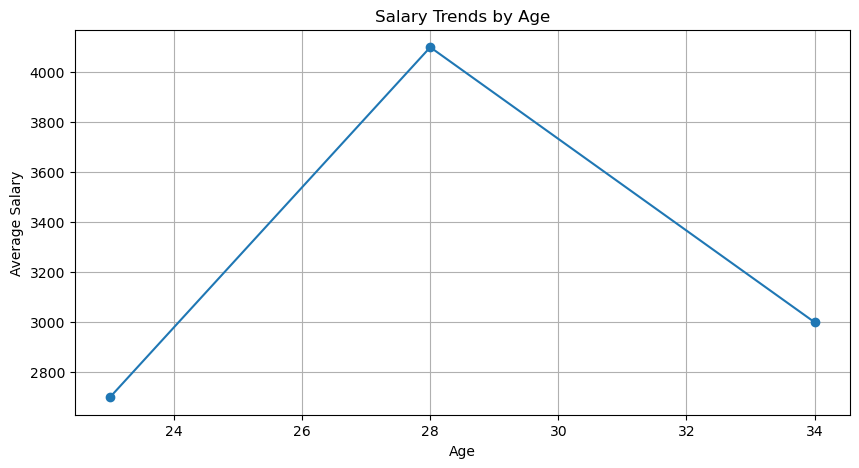

In [6]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("nyoba").getOrCreate()

# Dataset employees
employees = spark.createDataFrame([
    ('James', 34, 'M', 3000, 1),
    ('Anna', 28, 'F', 4100, 2),
    ('Lee', 23, 'M', 2700, 1)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

# Registrasi ke temporary view
employees.createOrReplaceTempView('employees')

# Query analisis rata-rata gaji berdasarkan usia
salary_trends = spark.sql('''
    SELECT Age, AVG(Salary) AS AverageSalary
    FROM employees
    GROUP BY Age
    ORDER BY Age
''').toPandas()

# (Opsional) Lihat hasil query
print(salary_trends)

# Visualisasi tren gaji berdasarkan usia
plt.figure(figsize=(10, 5))
plt.plot(salary_trends['Age'], salary_trends['AverageSalary'], marker='o')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.title('Salary Trends by Age')
plt.grid(True)
plt.show()



=== TUGAS 1: Total gaji & jumlah karyawan per departemen ===
          DeptName  TotalSalary  EmployeeCount
0      Engineering        41900              5
1          Finance        25400              4
2       Operations        22100              4
3  Human Resources        18500              4
4        Marketing        17500              3


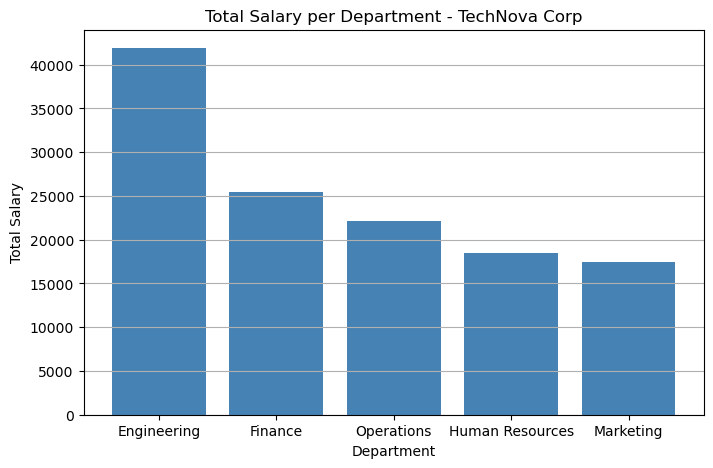


=== TUGAS 2: Karyawan dengan gaji di atas rata-rata tiap usia ===
   Name  Age  Salary
0  Mila   29    6100


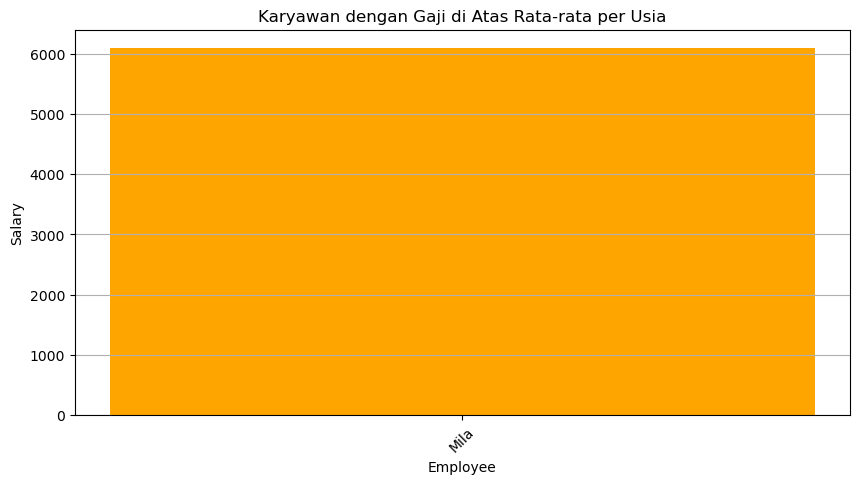

In [20]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd

# Inisialisasi SparkSession
spark = SparkSession.builder.appName("TechNovaCorp").getOrCreate()

# -----------------------------
# DATASET PERUSAHAAN TEKHNOVA
# -----------------------------
departments = spark.createDataFrame([
    (1, 'Human Resources'),
    (2, 'Finance'),
    (3, 'Engineering'),
    (4, 'Marketing'),
    (5, 'Operations')
], ['DeptId', 'DeptName'])

employees = spark.createDataFrame([
    # Name, Age, Gender, Salary, DeptId
    ('Alice', 29, 'F', 4200, 1),
    ('Bob', 35, 'M', 5200, 1),
    ('Clara', 31, 'F', 4800, 1),
    ('Daniel', 41, 'M', 7500, 2),
    ('Ella', 28, 'F', 4700, 2),
    ('Frank', 33, 'M', 6100, 2),
    ('Grace', 26, 'F', 7200, 3),
    ('Henry', 39, 'M', 9500, 3),
    ('Isabella', 30, 'F', 8400, 3),
    ('Jack', 45, 'M', 9900, 3),
    ('Kara', 27, 'F', 5600, 4),
    ('Leo', 32, 'M', 5800, 4),
    ('Mila', 29, 'F', 6100, 4),
    ('Nina', 40, 'F', 4900, 5),
    ('Oscar', 36, 'M', 5200, 5),
    ('Paul', 43, 'M', 6600, 5),
    ('Quinn', 38, 'F', 7100, 2),
    ('Ryan', 25, 'M', 6900, 3),
    ('Sophie', 34, 'F', 4300, 1),
    ('Tom', 37, 'M', 5400, 5)
], ['Name', 'Age', 'Gender', 'Salary', 'DeptId'])

# Registrasi tabel sementara
employees.createOrReplaceTempView('employees')
departments.createOrReplaceTempView('departments')

# =========================================================
#TUGAS 1: Total gaji dan jumlah karyawan per departemen
# =========================================================
tugas1 = spark.sql('''
    SELECT d.DeptName,
           SUM(e.Salary) AS TotalSalary,
           COUNT(e.Name) AS EmployeeCount
    FROM employees e
    JOIN departments d ON e.DeptId = d.DeptId
    GROUP BY d.DeptName
    ORDER BY TotalSalary DESC
''').toPandas()

print("=== TUGAS 1: Total gaji & jumlah karyawan per departemen ===")
print(tugas1)

plt.figure(figsize=(8,5))
plt.bar(tugas1['DeptName'], tugas1['TotalSalary'], color='steelblue')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.title('Total Salary per Department - TechNova Corp')
plt.grid(axis='y')
plt.show()

# =========================================================
#TUGAS 2: Karyawan dengan gaji di atas rata-rata dalam kelompok usia
# =========================================================
tugas2 = spark.sql('''
    WITH avg_salary_age AS (
        SELECT Age, AVG(Salary) AS avg_salary
        FROM employees
        GROUP BY Age
    )
    SELECT e.Name, e.Age, e.Salary
    FROM employees e
    JOIN avg_salary_age a ON e.Age = a.Age
    WHERE e.Salary > a.avg_salary
    ORDER BY e.Age
''').toPandas()

print("\n=== TUGAS 2: Karyawan dengan gaji di atas rata-rata tiap usia ===")
print(tugas2)

plt.figure(figsize=(10,5))
plt.bar(tugas2['Name'], tugas2['Salary'], color='orange')
plt.xlabel('Employee')
plt.ylabel('Salary')
plt.title('Karyawan dengan Gaji di Atas Rata-rata per Usia')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()



25/10/25 15:42:24 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Employee count: 120

Aggregate per department:
   DeptId         DeptName  EmployeeCount  TotalSalary  AverageSalary  \
0       3      Engineering             20       176000        8800.00   
1       6          Product             20       163450        8172.50   
2       4        Marketing             20       129500        6475.00   
3       2          Finance             20       128600        6430.00   
4       5       Operations             20       128475        6423.75   
5       1  Human Resources             20       117650        5882.50   

   MaxSalary  MinSalary  
0      10325       7400  
1       9700       6775  
2       8075       5075  
3       7975       4775  
4       8050       4825  
5       7775       3975  


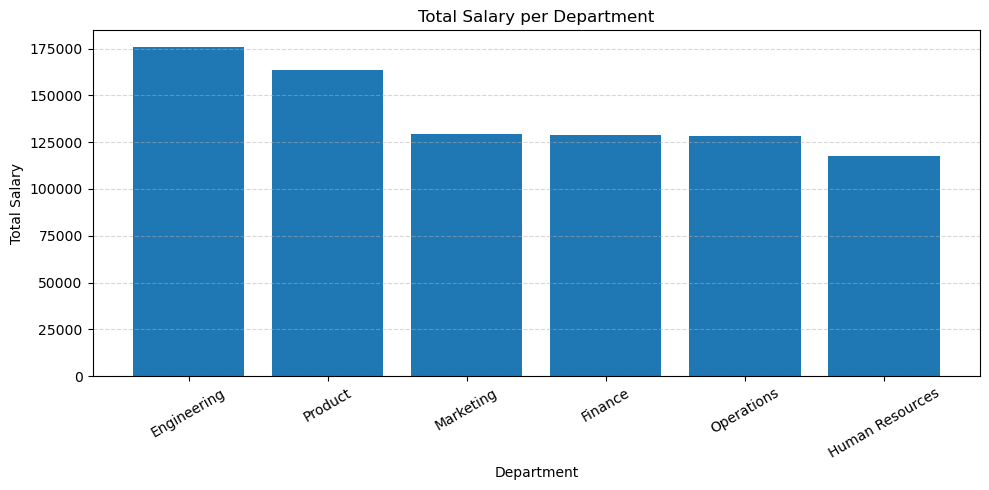

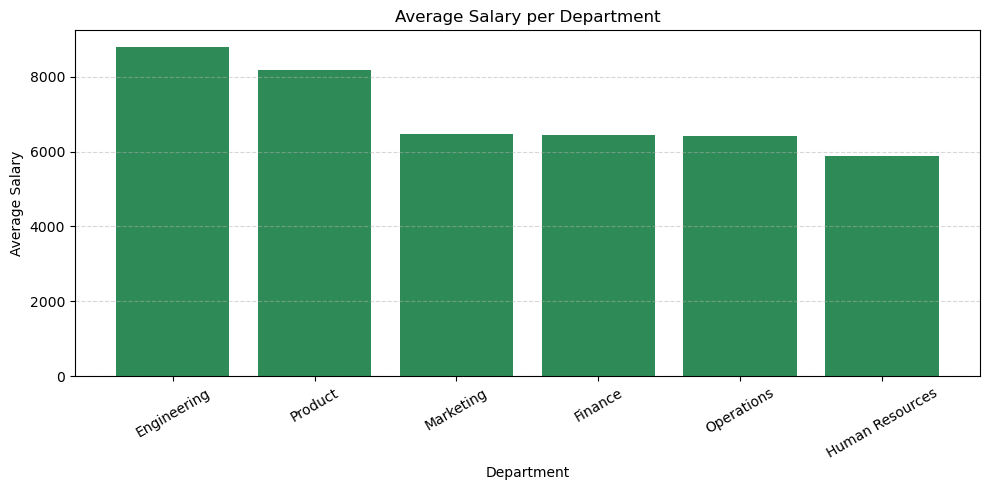


Top 3 per department (by salary):
    DeptId       Name               Role  Salary  SalaryRank
0        1   Mason_12          Recruiter    7775           1
1        1   Cara_102          Recruiter    7450           2
2        1   Kevin_90         HR Officer    7275           3
3        2   Dina_103         Controller    7975           1
4        2   Fiona_25    Finance Analyst    7875           2
5        2    Pia_115    Finance Analyst    7550           3
6        3  Quinn_116                SRE   10325           1
7        3     Sam_38  Software Engineer   10075           2
8        3    Cara_62                SRE   10075           2
9        4    Luna_51     SEO Specialist    8075           1
10       4     Pia_75     Marketing Spec    7925           2
11       4    Hana_87     SEO Specialist    7500           3
12       5   Quinn_76          Ops Coord    8050           1
13       5    Evan_64          Logistics    7775           2
14       5   Kevin_10          Logistics    7525  

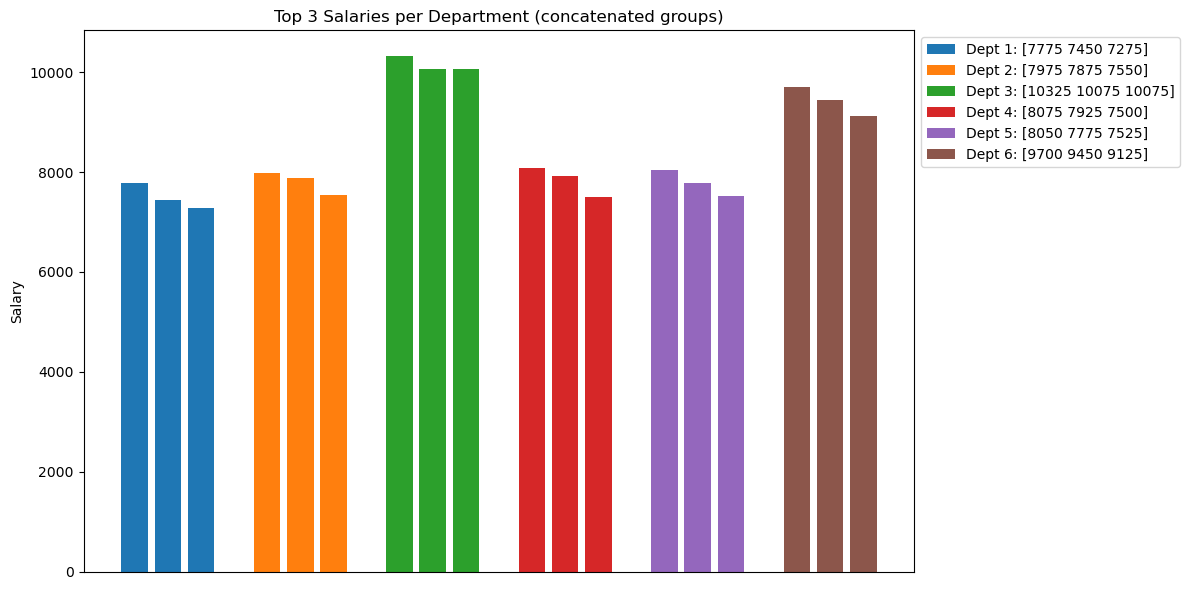


Employees with salary above their department average:
         Name  DeptId             Role  Salary  DeptAvg
0     Jill_89       6    UX Researcher    9700  8172.50
1     Luna_11       6     PM Assistant    9450  8172.50
2     Ben_101       6     PM Assistant    9125  8172.50
3     Rita_77       6  Product Manager    8975  8172.50
4     Hana_47       6     PM Assistant    8875  8172.50
5      Pia_35       6    UX Researcher    8750  8172.50
6     Dina_23       6  Product Manager    8725  8172.50
7    Nora_113       6  Product Manager    8400  8172.50
8     Dina_83       6     PM Assistant    8300  8172.50
9     Luna_71       6    UX Researcher    8175  8172.50
10   Quinn_76       5        Ops Coord    8050  6423.75
11    Evan_64       5        Logistics    7775  6423.75
12   Kevin_10       5        Logistics    7525  6423.75
13   Alex_100       5        Logistics    7200  6423.75
14     Ian_88       5      Ops Manager    7175  6423.75
15    Cara_22       5        Ops Coord    7100  6

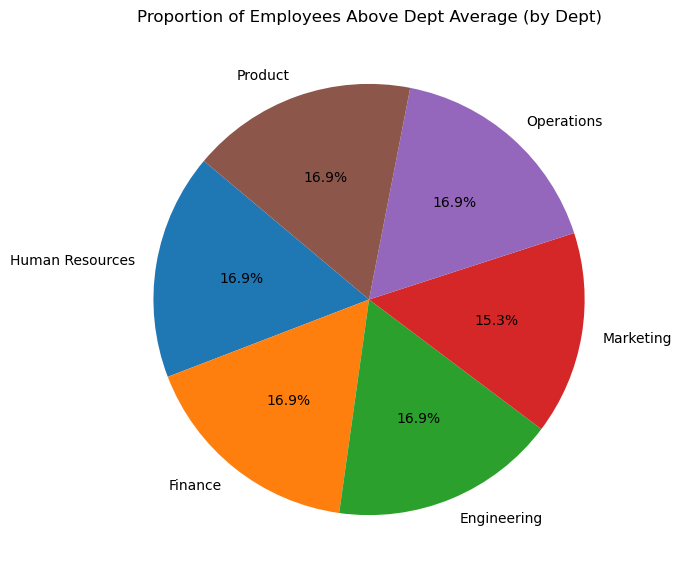

<Figure size 1000x600 with 0 Axes>

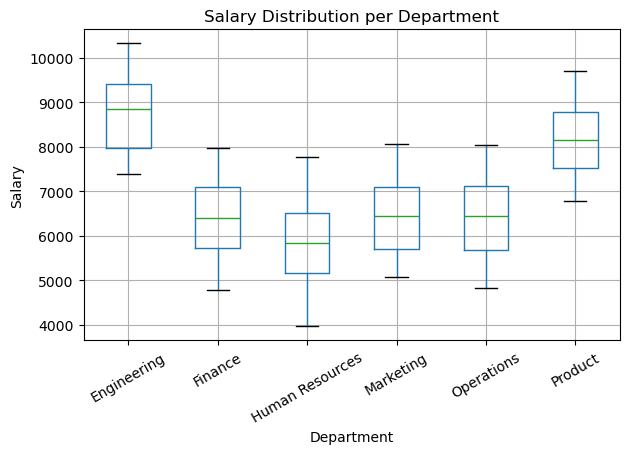

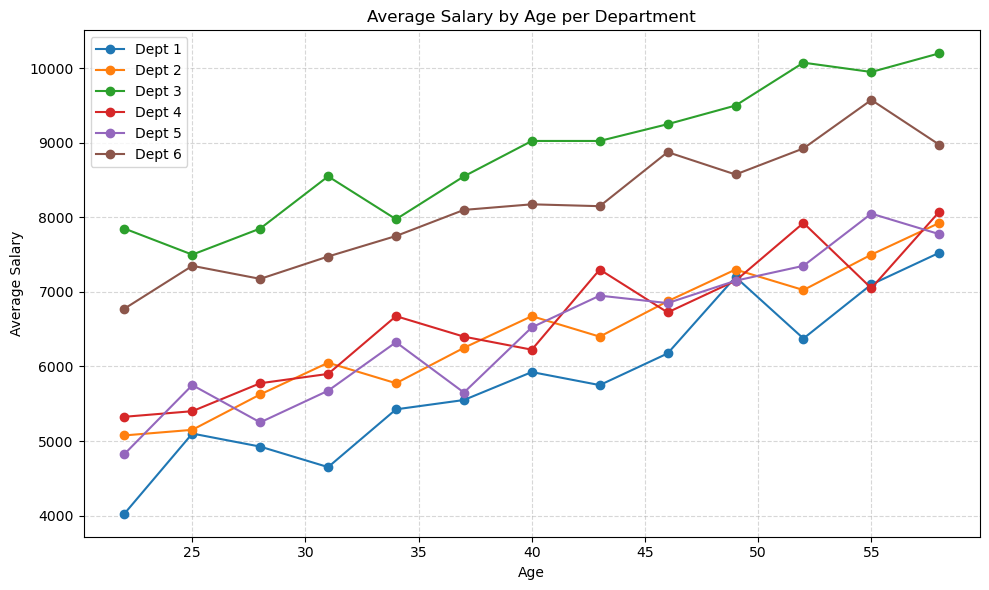


Sample joined rows:
      Name  Age Gender             Role  Salary DeptName         ProjectName
0  Fiona_5   37      F  Product Manager    7900  Product  New Product Launch
1  Luna_11   55      F     PM Assistant    9450  Product  New Product Launch
2  Rita_17   34      F    UX Researcher    7925  Product  New Product Launch
3  Dina_23   52      F  Product Manager    8725  Product  New Product Launch
4  Jill_29   31      F     PM Assistant    7350  Product  New Product Launch

Saved dept_summary.csv to current working directory.


25/10/25 19:31:30 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1851659 ms exceeds timeout 120000 ms
25/10/25 19:31:30 WARN SparkContext: Killing executors is not supported by current scheduler.
25/10/25 19:31:35 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:124)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$

In [21]:
# Script: Analisis mendalam perusahaan (100+ karyawan) menggunakan PySpark + Matplotlib
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1) Inisialisasi Spark
# ---------------------------
spark = SparkSession.builder \
    .appName("CompanyDeepAnalysis") \
    .config("spark.ui.port", "4050") \
    .getOrCreate()

# ---------------------------
# 2) Buat tabel departments & projects
# ---------------------------
departments = spark.createDataFrame([
    (1, "Human Resources"),
    (2, "Finance"),
    (3, "Engineering"),
    (4, "Marketing"),
    (5, "Operations"),
    (6, "Product")
], ["DeptId", "DeptName"])
departments.createOrReplaceTempView("departments")

projects = spark.createDataFrame([
    (1, "HR Onboarding"),
    (2, "Financial Q2 Reporting"),
    (3, "Platform Rework"),
    (4, "Brand Campaign"),
    (5, "Ops Efficiency"),
    (6, "New Product Launch")
], ["DeptId", "ProjectName"])
projects.createOrReplaceTempView("projects")

# ---------------------------
# 3) Buat dataset employees (>100 rows) deterministik
# ---------------------------
first_names = [
    "Alex","Ben","Cara","Dina","Evan","Fiona","George","Hana","Ian","Jill",
    "Kevin","Luna","Mason","Nora","Oscar","Pia","Quinn","Rita","Sam","Tara"
]
genders = ["M", "F"]
roles_by_dept = {
    1: ["HR Officer","HR Manager","Recruiter"],
    2: ["Accountant","Finance Analyst","Controller"],
    3: ["Software Engineer","SRE","Tech Lead"],
    4: ["Marketing Spec","Content Creator","SEO Specialist"],
    5: ["Ops Coord","Logistics","Ops Manager"],
    6: ["Product Manager","PM Assistant","UX Researcher"]
}

employees_data = []
num_employees = 120  # >100

for i in range(num_employees):
    # deterministic choice of name/gender/age/department/role
    name = f"{first_names[i % len(first_names)]}_{i}"
    gender = genders[i % len(genders)]
    age = 22 + ((i * 3) % 39)  # ages 22..60 in deterministic cycle
    dept = (i % len(departments.collect())) + 1  # 1..6
    role_list = roles_by_dept[dept]
    role = role_list[(i // len(departments.collect())) % len(role_list)]
    # salary formula: base by dept + role offset + age factor + small deterministic variation
    base_by_dept = {1:4200, 2:5000, 3:7000, 4:4800, 5:4600, 6:6500}
    role_offset = (len(role) % 5) * 150
    age_factor = (age - 25) * 75
    variation = (i % 7) * 100
    salary = base_by_dept[dept] + role_offset + age_factor + variation
    employees_data.append((name, age, gender, salary, dept, role))

employees = spark.createDataFrame(
    employees_data,
    ["Name", "Age", "Gender", "Salary", "DeptId", "Role"]
)
employees.createOrReplaceTempView("employees")

# quick check
print("Employee count:", employees.count())

# ---------------------------
# 4) Tugas Analitis: SUM, AVG, COUNT per dept (JOIN)
# ---------------------------
agg_dept = spark.sql('''
SELECT d.DeptId, d.DeptName,
       COUNT(e.Name) AS EmployeeCount,
       SUM(e.Salary) AS TotalSalary,
       ROUND(AVG(e.Salary), 2) AS AverageSalary,
       MAX(e.Salary) AS MaxSalary,
       MIN(e.Salary) AS MinSalary
FROM employees e
JOIN departments d ON e.DeptId = d.DeptId
GROUP BY d.DeptId, d.DeptName
ORDER BY AverageSalary DESC
''')
agg_dept_pd = agg_dept.toPandas()
print("\nAggregate per department:")
print(agg_dept_pd)

# Visualisasi: Total Salary per Dept
plt.figure(figsize=(10,5))
plt.bar(agg_dept_pd['DeptName'], agg_dept_pd['TotalSalary'])
plt.title('Total Salary per Department')
plt.xlabel('Department')
plt.ylabel('Total Salary')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Visualisasi: Average Salary per Dept (sorted)
plt.figure(figsize=(10,5))
plt.bar(agg_dept_pd['DeptName'], agg_dept_pd['AverageSalary'], color='seagreen')
plt.title('Average Salary per Department')
plt.xlabel('Department')
plt.ylabel('Average Salary')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------
# 5) Ranking karyawan dalam departemen (window function)
# ---------------------------
window_dept = Window.partitionBy("DeptId").orderBy(F.col("Salary").desc())
ranked = employees.withColumn("SalaryRank", F.rank().over(window_dept))
ranked.createOrReplaceTempView("ranked_employees")

# top 3 per dept
top3_per_dept = spark.sql('''
SELECT DeptId, Name, Role, Salary, SalaryRank
FROM ranked_employees
WHERE SalaryRank <= 3
ORDER BY DeptId, SalaryRank
''')
top3_pd = top3_per_dept.toPandas()
print("\nTop 3 per department (by salary):")
print(top3_pd)

# Visual: Top 3 per dept (bar chart grouping)
# We'll plot for each dept a grouped bar chart of top 3 salaries
import numpy as np
grouped = top3_pd.groupby("DeptId")
plt.figure(figsize=(12,6))
for idx, (deptid, grp) in enumerate(grouped):
    x = np.arange(len(grp)) + idx*(len(grp)+1)
    plt.bar(x, grp["Salary"], label=f"Dept {deptid}: {grp['Salary'].values}")
plt.title("Top 3 Salaries per Department (concatenated groups)")
plt.ylabel("Salary")
plt.xticks([])
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# ---------------------------
# 6) Employees with salary > dept average (window)
# ---------------------------
# Use window AVG over partition
avg_window = Window.partitionBy("DeptId")
emp_above_avg = employees.withColumn("DeptAvg", F.round(F.avg("Salary").over(avg_window),2)) \
                         .filter(F.col("Salary") > F.col("DeptAvg")) \
                         .select("Name","DeptId","Role","Salary","DeptAvg") \
                         .orderBy("DeptId","Salary", ascending=False)
emp_above_avg_pd = emp_above_avg.toPandas()
print("\nEmployees with salary above their department average:")
print(emp_above_avg_pd.head(20))

# Visual: count of above-average employees per department (pie)
counts_above = emp_above_avg.groupBy("DeptId").count().toPandas()
counts_above = counts_above.merge(agg_dept_pd[['DeptId','DeptName']], on='DeptId')
plt.figure(figsize=(7,7))
plt.pie(counts_above['count'], labels=counts_above['DeptName'], autopct='%1.1f%%', startangle=140)
plt.title('Proportion of Employees Above Dept Average (by Dept)')
plt.show()

# ---------------------------
# 7) Distribusi gaji per departemen (boxplot)
# ---------------------------
# Convert full employees salary data to pandas grouped by DeptName
salary_by_dept_pd = employees.join(departments, on="DeptId").select("DeptName","Salary").toPandas()
plt.figure(figsize=(10,6))
salary_by_dept_pd.boxplot(by='DeptName', column=['Salary'], rot=30)
plt.title('Salary Distribution per Department')
plt.suptitle('')
plt.xlabel('Department')
plt.ylabel('Salary')
plt.tight_layout()
plt.show()

# ---------------------------
# 8) Tren gaji berdasarkan usia per dept (moving average by age)
# ---------------------------
# Compute average salary per age per department
age_trend = spark.sql('''
SELECT DeptId, Age, ROUND(AVG(Salary),2) AS AvgSalary
FROM employees
GROUP BY DeptId, Age
ORDER BY DeptId, Age
''').toPandas()

# Example plot: for 2-3 departments plot AvgSalary vs Age
plt.figure(figsize=(10,6))
for deptid in sorted(age_trend['DeptId'].unique()):
    subset = age_trend[age_trend['DeptId']==deptid]
    plt.plot(subset['Age'], subset['AvgSalary'], marker='o', label=f"Dept {deptid}")
plt.title('Average Salary by Age per Department')
plt.xlabel('Age')
plt.ylabel('Average Salary')
plt.legend(loc='best')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# ---------------------------
# 9) Contoh JOIN lebih kompleks: employees + departments + projects (one row per employee)
# ---------------------------
joined = spark.sql('''
SELECT e.Name, e.Age, e.Gender, e.Role, e.Salary, d.DeptName, p.ProjectName
FROM employees e
LEFT JOIN departments d ON e.DeptId = d.DeptId
LEFT JOIN projects p ON e.DeptId = p.DeptId
''')
joined_pd = joined.toPandas()
print("\nSample joined rows:")
print(joined_pd.head())

# ---------------------------
# 10) Simpulan & simpan hasil ringkasan (opsional)
# ---------------------------
# Simpan agg_dept ke CSV lokal (opsional)
agg_dept_pd.to_csv("dept_summary.csv", index=False)
print("\nSaved dept_summary.csv to current working directory.")

# stop spark if you want
# spark.stop()
